In [399]:
import datetime
import time

# Import libraries use for visualization and analysis
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import cufflinks as cf

# Import the Monasca and Keystone clients
from monascaclient import client
from monascaclient import ksclient

from pandas import Series,DataFrame

# Import library to execute remote commands for monasca-agent demo
import spur
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
'''%export OS_PROJECT_NAME=mini-mon
%export OS_PASSWORD=password
%export OS_AUTH_URL=http://157.159.232.218:35357/v3/
%export OS_USERNAME=mini-mon
%export MONASCA_API_URL=http://157.159.232.217:8070/v2.0/'''
monasca_url = 'http://157.159.232.217:8070/v2.0/'

In [257]:
api_version = '2_0'

# Authenticate to Keystone
keystone_url = 'http://157.159.232.218:35357/v3/'
ks = ksclient.KSClient(auth_url=keystone_url, username='mini-mon', password='password')

# construct the mon client
monasca_client = client.Client(api_version, monasca_url, token=ks.token)
# call the metric-create command
'''
dimensions = {'instance_id': '12345', 'service': 'hello'}
fields = {}
fields['name'] = 'cindy1'
fields['dimensions'] = dimensions
fields['timestamp'] = time.time()
fields['value'] = 222.333'''


"\ndimensions = {'instance_id': '12345', 'service': 'hello'}\nfields = {}\nfields['name'] = 'cindy1'\nfields['dimensions'] = dimensions\nfields['timestamp'] = time.time()\nfields['value'] = 222.333"

In [21]:
try:
    resp = monasca_client.metrics.list();   
except exc.HTTPException as he:
    print(he.code)
    print(he.message)
else:
    print(resp)

IndentationError: expected an indented block (<ipython-input-21-779f71898ff2>, line 7)

In [159]:
#monasca_client.metrics.list_measurements('2014-01-01T00:00:00Z');

In [6]:
shell = spur.SshShell(hostname='157.159.232.217',username='ubuntu',missing_host_key=spur.ssh.MissingHostKey.accept,private_key_file='/home/jaafar/Downloads/ici.pem');

In [161]:
# for testing
T = shell.run(["ifconfig"])

In [162]:
#T = shell.run(["monasca","measurement-list","cpu.user_perc", "2016-05-20T15:52:26.0C"])

In [163]:
#result = shell.run(["export", "OS_PROJECT_NAME=mini-mon"])#,["export", "OS_PASSWORD=password"],["export", "OS_AUTH_URL=http://157.159.232.218:35357/v3"],["export", "OS_USERNAME=mini-mon"])#
print(result.output) # prints hello

hello


In [164]:
#result = shell.run(["monasca","metric-list"])
#print(result.output) # prints hello

In [165]:
# sync clock
# shell.run(['sudo', 'ntpdate', 'time.nist.gov'])

In [7]:
def get_metrics(names=[None], dimensions={}, limit=10):
    metrics = []
    for name in names:        
        # Invoke the Monasca client
        metrics = metrics + monasca_client.metrics.list(name=name, dimensions=dimensions, limit=limit)
    return metrics

In [8]:
def get_measurements(metrics, start_time = None, end_time = None, limit=None):
    measurements = []
    
    if start_time == None:
        start_date = datetime.datetime.utcnow() - datetime.timedelta(seconds=3600)
        start_time = start_date.strftime("%Y-%m-%dT%H:%M:%SZ")

    if end_time == None:
        end_date = datetime.datetime.utcnow() - datetime.timedelta(seconds=0)
        end_time = end_date.strftime("%Y-%m-%dT%H:%M:%SZ")
        
    for metric in metrics:        
        # Invoke the Monasca client
        measurements.append(monasca_client.metrics.list_measurements(
                name=metric['name'],
                dimensions=metric['dimensions'],
                start_time=start_time,
                end_time=end_time))
        
    return measurements

In [9]:
def df_from_measurements(measurements, group_by=[]):
    '''Returns a DataFrame given measurements'''
    measurement = measurements[1]
    m = np.array(measurement[0]['measurements'])  
    timestamps = m[:, measurement[0]['columns'].index('timestamp')]
    df = pd.DataFrame(index = timestamps)  
    
    for measurement in measurements:
        if measurement:
            measure = measurement
            m = np.array(measure[0]['measurements'])
            name = measure[0]['name']
            dimensions = measure[0]['dimensions']
        
            for group in group_by:
                if group in dimensions:
                    name += '.' + dimensions[group]
            #df[name] = m[:measure[1][0]['columns'].index('value')]     
    return df



In [336]:
metrics = get_metrics(names=['cpu.user_perc', 'cpu.system_perc'])
measurements = get_measurements(metrics,"2016-05-15T15:52:26.0Z","2016-05-20T15:55:26.0Z")

In [659]:
i = 0;
max = len(measurements);
for measure in measurements:
    if measure:
       
        data = np.array(measure[0]['measurements'])
        metric_name = measure[0]['name']
        hostname = measure[0]['dimensions'].get('hostname')
        service = measure[0]['dimensions'].get('service')
        timestamp = ["" for x in range(len(data))] 
        values = np.zeros(len(data))
        i = i + 1;
        i=0;
        if hostname == "mini-mon" and metric_name == "cpu.user_perc":
            for d in data:
                timestamp[i] = d[0]
                values[i] = d[1]
                i = i + 1
            df = pd.DataFrame(index = timestamp)
            df['name'] = metric_name
            df[service] = service
            df[hostname] = hostname
            df['valeur'] = values
            df['time'] = np.arange(len(timestamp))

In [660]:
measurements;

In [729]:
df;

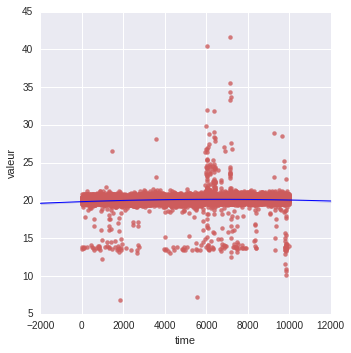

In [730]:
sns.lmplot('time','valeur',df,order=2,scatter_kws={'marker':'o','color':'indianred'},line_kws={'linewidth':1,'color':'blue'})

In [731]:
for i in range(len(df.valeur)):
    v = df.valeur[i];
#sns.boxplot(df.values,saturation=1.7)

In [851]:
v = np.asarray(df.valeur)
#v = v[:300]
#v

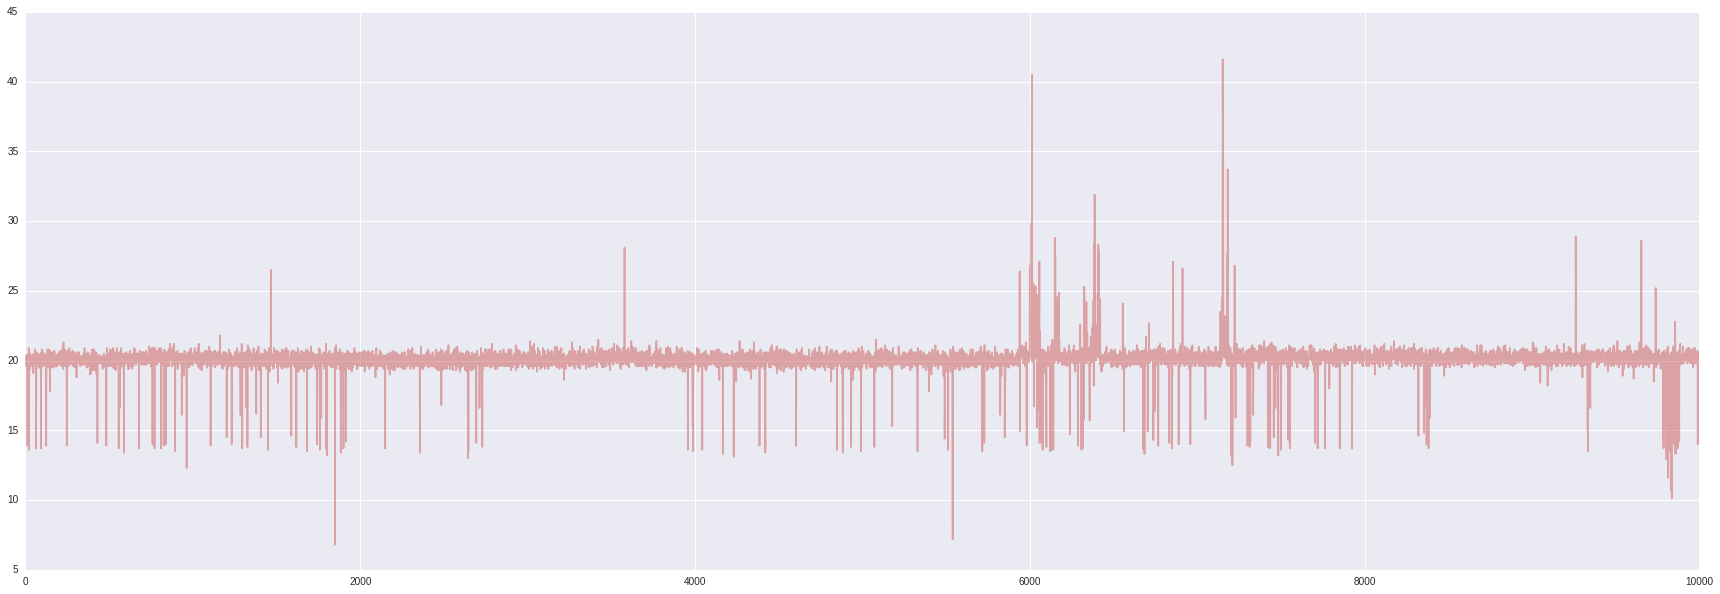

In [852]:
tmps =np.arange(v.size)
plt.subplots(figsize=(30, 10))
plt.plot(tmps,v,color='indianred',alpha=0.5)

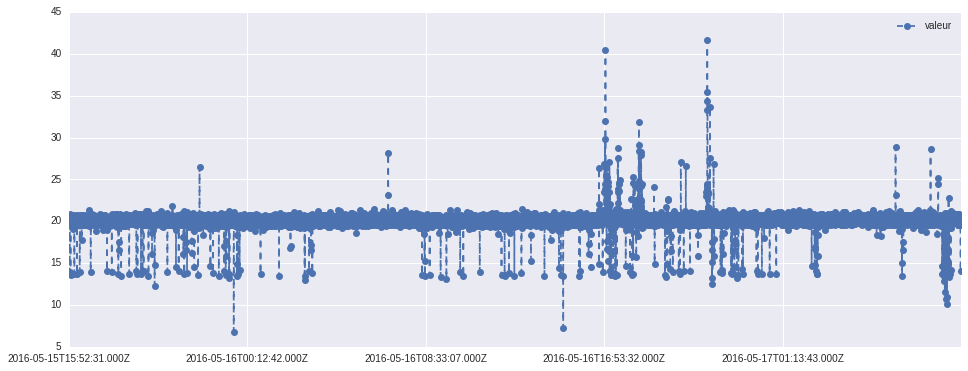

In [853]:

# We'll use pct_change to find the percent change for each day
df['perc_change'] = df['valeur'].pct_change()
# Then we'll plot the daily return percentage
df['valeur'].plot(figsize=(16,6),legend=True,linestyle='--',marker='o')



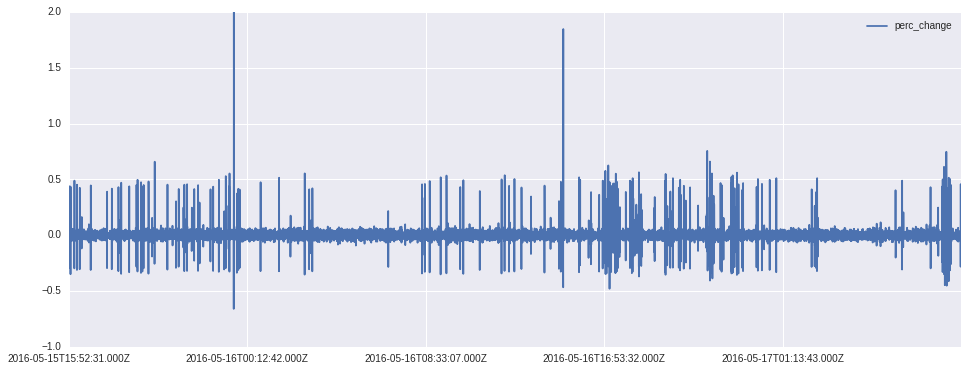

In [854]:
df['perc_change'].plot(figsize=(16,6),legend=True,linestyle='-',marker='x')

In [855]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    df[column_name]=pd.rolling_mean(df['valeur'],ma)

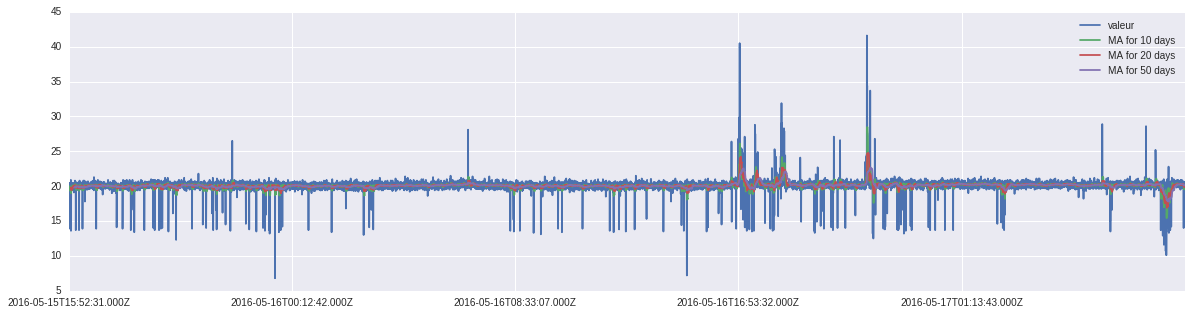

In [856]:
df[['valeur','MA for 10 days','MA for 20 days','MA for 50 days']].plot(subplots=False,figsize=(20,5))

In [857]:
xmin = v.min()
xmax = v.max()
x2 = v.copy()
x2 -= xmin
x2 /= (xmax-xmin)
v=x2[100:1000].copy()

In [858]:
window = 10;
y = v[window:]
Y = [ [y[i]] for i in range(y.size) ]
X =  np.resize(v,(v.size/window,window))
y_l = Y
X_l = X.tolist()
X_l;

In [860]:
from ann import ANN

# 4 input neurons: sepal length (cm),sepal width (cm), petal length (cm), petal width (cm)
# 10 hidden neurons
# 3 output neurons: setosa [1, 0, 0], versicolor [0, 1, 0], virginica [0, 0, 1]
nn = ANN([10,21,1], activation_fun='linear')


# Here please Try to represent the input data as percentage so that you can capture patterns

# train the ANN
#nn.train(inputs, targets, 1600)
nn.train(X_l,y_l,200)

(0, 0.056350211223878358)
(100, 0.021955783278140437)


In [861]:
h = [ nn.predict(X_l[i]) for i in range(len(X_l))]

In [862]:
h_arr = np.asarray(h)
y_arr = np.asarray(y_l)
error = ((h_arr - y_arr[:h_arr.size])**2)

In [864]:
MSE = np.mean(error)

In [865]:
MSE

0.00040265351694505777

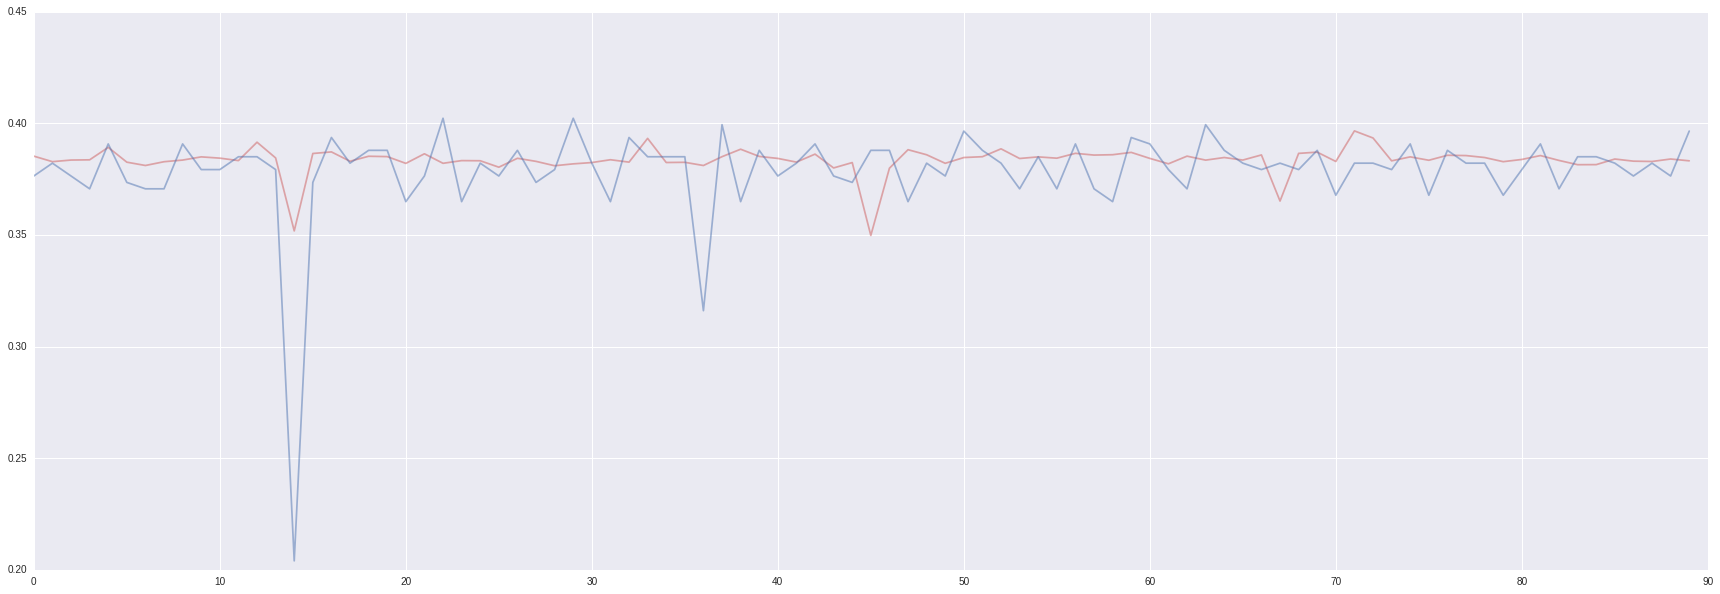

In [866]:
plt.subplots(figsize=(30, 10))
tmps = np.arange(h_arr.size)

plt.plot(tmps,h_arr,color='indianred',alpha=0.5)
plt.plot(tmps,y_arr[:h_arr.size],alpha=0.5)

In [877]:
nn.predict(X_l[0])[0]

0.38532898564767271

In [876]:
h_out = np.zeros(len(y_l)+window)
for i in range(len(y_l)):
    if i >= window:
        h_out[i] = nn.predict(X_l[i])[0]*(xmax-xmin)+xmin
    else:
        h_out[i] = 0

IndexError: list index out of range

In [789]:
#h = [ [i] for i in np.zeros(window);  ] 
#h.append(h_arr);

I = np.arange(h_out.size)
df2 = DataFrame(h_out,I,columns=['pred'])
#df['predict'] = h_arr
df_resultat = pd.merge(df,df2,right_index=True,left_on='time')#,left_on=True,right_on=True)
df_resultat

,name,monitoring,mini-mon,valeur,time,perc_change,MA for 10 days,MA for 20 days,MA for 50 days,pred
2016-05-15T15:52:31.000Z,cpu.user_perc,monitoring,mini-mon,19.9,0,NaN,NaN,NaN,NaN,0
2016-05-15T15:52:46.000Z,cpu.user_perc,monitoring,mini-mon,19.8,1,-0.005025,NaN,NaN,NaN,0
2016-05-15T15:53:01.000Z,cpu.user_perc,monitoring,mini-mon,20.2,2,0.020202,NaN,NaN,NaN,0
2016-05-15T15:53:16.000Z,cpu.user_perc,monitoring,mini-mon,19.9,3,-0.014851,NaN,NaN,NaN,0
2016-05-15T15:53:31.000Z,cpu.user_perc,monitoring,mini-mon,19.9,4,0.000000,NaN,NaN,NaN,0
2016-05-15T15:53:46.000Z,cpu.user_perc,monitoring,mini-mon,19.6,5,-0.015075,NaN,NaN,NaN,0
2016-05-15T15:54:01.000Z,cpu.user_perc,monitoring,mini-mon,20.4,6,0.040816,NaN,NaN,NaN,0
2016-05-15T15:54:16.000Z,cpu.user_perc,monitoring,mini-mon,19.6,7,-0.039216,NaN,NaN,NaN,0
2016-05-15T15:54:31.000Z,cpu.user_perc,monitoring,mini-mon,20.1,8,0.025510,NaN,NaN,NaN,0
2016-05-15T15:54:46.000Z,cpu.user_perc,monitoring,mini-mon,20.0,9,-0.004975,19.94,NaN,NaN,0


In [ ]:
df_resultat[['valeur','pred']].plot(subplots=False,figsize=(20,5))